In [77]:
import gym
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Hyperparameters
learning_rate = 0.0005
gamma = 0.98
buffer_limit = 50000
batch_size = 32


class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
            torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
            torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)


class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0, 1)
        else:
            return out.argmax().item()


def train(q, q_target, memory, optimizer):
    for i in range(10):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1, a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def main():
    env = gym.make('CartPole-v1')
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()
    
    cache = []
    steps = []
    print_interval = 20
    score = 0.0
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for n_epi in range(10000):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)
                      )  # Linear annealing from 8% to 1%
        s = env.reset()
        step = 0
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s, a, r/100.0, s_prime, done_mask))
            s = s_prime
            score += r
            step += 1
            
            if done:
                steps.append(step)
                break

        if memory.size() > 2000:
            train(q, q_target, memory, optimizer)

        if n_epi % print_interval == 0 and n_epi != 0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                n_epi ,score/print_interval, memory.size(), epsilon*100))
            cache.append(score/print_interval)
            score = 0.0
    env.close()
    
    return steps , cache

In [78]:
steps, cache = main()

n_episode :20, score : 9.9, n_buffer : 198, eps : 7.9%
n_episode :40, score : 10.0, n_buffer : 398, eps : 7.8%
n_episode :60, score : 9.3, n_buffer : 585, eps : 7.7%
n_episode :80, score : 9.7, n_buffer : 778, eps : 7.6%
n_episode :100, score : 10.1, n_buffer : 979, eps : 7.5%
n_episode :120, score : 9.8, n_buffer : 1176, eps : 7.4%
n_episode :140, score : 9.2, n_buffer : 1360, eps : 7.3%
n_episode :160, score : 9.6, n_buffer : 1552, eps : 7.2%
n_episode :180, score : 9.7, n_buffer : 1746, eps : 7.1%
n_episode :200, score : 9.3, n_buffer : 1933, eps : 7.0%
n_episode :220, score : 9.9, n_buffer : 2132, eps : 6.9%
n_episode :240, score : 10.4, n_buffer : 2340, eps : 6.8%
n_episode :260, score : 10.6, n_buffer : 2551, eps : 6.7%
n_episode :280, score : 10.2, n_buffer : 2756, eps : 6.6%
n_episode :300, score : 9.9, n_buffer : 2955, eps : 6.5%
n_episode :320, score : 10.6, n_buffer : 3167, eps : 6.4%
n_episode :340, score : 12.2, n_buffer : 3410, eps : 6.3%
n_episode :360, score : 14.8, n_b

n_episode :2760, score : 253.4, n_buffer : 50000, eps : 1.0%
n_episode :2780, score : 402.8, n_buffer : 50000, eps : 1.0%
n_episode :2800, score : 455.0, n_buffer : 50000, eps : 1.0%
n_episode :2820, score : 308.2, n_buffer : 50000, eps : 1.0%
n_episode :2840, score : 345.8, n_buffer : 50000, eps : 1.0%
n_episode :2860, score : 387.1, n_buffer : 50000, eps : 1.0%
n_episode :2880, score : 284.2, n_buffer : 50000, eps : 1.0%
n_episode :2900, score : 364.5, n_buffer : 50000, eps : 1.0%
n_episode :2920, score : 190.3, n_buffer : 50000, eps : 1.0%
n_episode :2940, score : 251.7, n_buffer : 50000, eps : 1.0%
n_episode :2960, score : 339.5, n_buffer : 50000, eps : 1.0%
n_episode :2980, score : 351.9, n_buffer : 50000, eps : 1.0%
n_episode :3000, score : 428.6, n_buffer : 50000, eps : 1.0%
n_episode :3020, score : 398.9, n_buffer : 50000, eps : 1.0%
n_episode :3040, score : 418.0, n_buffer : 50000, eps : 1.0%
n_episode :3060, score : 314.7, n_buffer : 50000, eps : 1.0%
n_episode :3080, score :

n_episode :5460, score : 435.9, n_buffer : 50000, eps : 1.0%
n_episode :5480, score : 472.4, n_buffer : 50000, eps : 1.0%
n_episode :5500, score : 306.8, n_buffer : 50000, eps : 1.0%
n_episode :5520, score : 417.1, n_buffer : 50000, eps : 1.0%
n_episode :5540, score : 390.6, n_buffer : 50000, eps : 1.0%
n_episode :5560, score : 270.5, n_buffer : 50000, eps : 1.0%
n_episode :5580, score : 245.2, n_buffer : 50000, eps : 1.0%
n_episode :5600, score : 145.6, n_buffer : 50000, eps : 1.0%
n_episode :5620, score : 109.6, n_buffer : 50000, eps : 1.0%
n_episode :5640, score : 140.6, n_buffer : 50000, eps : 1.0%
n_episode :5660, score : 53.2, n_buffer : 50000, eps : 1.0%
n_episode :5680, score : 194.5, n_buffer : 50000, eps : 1.0%
n_episode :5700, score : 226.8, n_buffer : 50000, eps : 1.0%
n_episode :5720, score : 426.6, n_buffer : 50000, eps : 1.0%
n_episode :5740, score : 500.0, n_buffer : 50000, eps : 1.0%
n_episode :5760, score : 465.6, n_buffer : 50000, eps : 1.0%
n_episode :5780, score : 

n_episode :8160, score : 314.6, n_buffer : 50000, eps : 1.0%
n_episode :8180, score : 293.3, n_buffer : 50000, eps : 1.0%
n_episode :8200, score : 240.6, n_buffer : 50000, eps : 1.0%
n_episode :8220, score : 422.1, n_buffer : 50000, eps : 1.0%
n_episode :8240, score : 427.3, n_buffer : 50000, eps : 1.0%
n_episode :8260, score : 422.6, n_buffer : 50000, eps : 1.0%
n_episode :8280, score : 386.2, n_buffer : 50000, eps : 1.0%
n_episode :8300, score : 382.5, n_buffer : 50000, eps : 1.0%
n_episode :8320, score : 410.1, n_buffer : 50000, eps : 1.0%
n_episode :8340, score : 318.1, n_buffer : 50000, eps : 1.0%
n_episode :8360, score : 376.5, n_buffer : 50000, eps : 1.0%
n_episode :8380, score : 357.1, n_buffer : 50000, eps : 1.0%
n_episode :8400, score : 294.1, n_buffer : 50000, eps : 1.0%
n_episode :8420, score : 231.3, n_buffer : 50000, eps : 1.0%
n_episode :8440, score : 307.2, n_buffer : 50000, eps : 1.0%
n_episode :8460, score : 300.2, n_buffer : 50000, eps : 1.0%
n_episode :8480, score :

In [98]:
999*10

9990

In [ ]:
0~9 10~19 ... 9990~9999

In [110]:
refined_steps

[9.5,
 9.85,
 9.45,
 9.65,
 10.0,
 9.85,
 9.2,
 9.6,
 9.75,
 9.3,
 9.9,
 10.35,
 10.6,
 10.3,
 9.95,
 10.6,
 11.65,
 14.95,
 16.6,
 13.2,
 20.4,
 51.2,
 40.15,
 149.25,
 183.8,
 159.85,
 193.5,
 121.75,
 126.85,
 115.0,
 110.55,
 149.0,
 220.55,
 195.4,
 207.15,
 237.5,
 209.2,
 196.8,
 217.15,
 168.5,
 338.35,
 217.15,
 171.55,
 289.5,
 325.6,
 366.1,
 228.5,
 210.1,
 251.1,
 291.9,
 276.2,
 313.2,
 259.55,
 335.3,
 373.15,
 368.45,
 295.65,
 279.25,
 319.55,
 264.15,
 287.7,
 219.25,
 338.9,
 182.85,
 316.45,
 271.6,
 318.95,
 187.45,
 75.3,
 368.7,
 342.85,
 335.55,
 362.25,
 260.25,
 128.55,
 177.55,
 220.6,
 214.55,
 351.5,
 388.8,
 321.75,
 351.35,
 406.6,
 441.2,
 407.8,
 268.1,
 361.8,
 467.35,
 411.25,
 385.2,
 285.95,
 298.95,
 402.05,
 271.8,
 372.7,
 145.1,
 224.4,
 211.0,
 243.45,
 221.2,
 180.95,
 199.65,
 236.9,
 244.75,
 202.35,
 305.85,
 243.9,
 238.55,
 268.9,
 183.8,
 316.15,
 375.45,
 348.3,
 215.0,
 288.3,
 246.6,
 381.7,
 432.15,
 290.4,
 356.35,
 345.55,
 333.15,

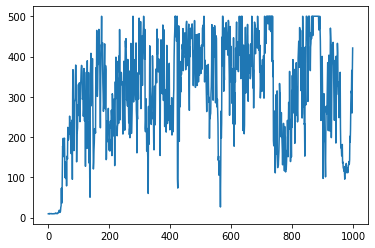

In [111]:
refined_steps_one = []
for i in range(1000):
    n = 10*i #0, 10, 20, ... , 9990
    refined_steps_one.append(np.mean(steps[n:n+10]))
plt.plot(refined_steps_one)

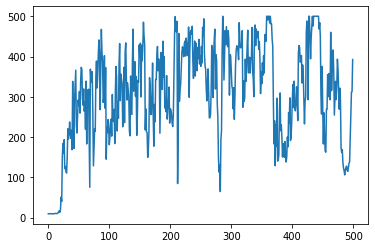

In [112]:
refined_steps_two = []
for i in range(500):
    n = 20*i #0, 20, 40, ... , 9980
    refined_steps_two.append(np.mean(steps[n:n+20]))
plt.plot(refined_steps_two)

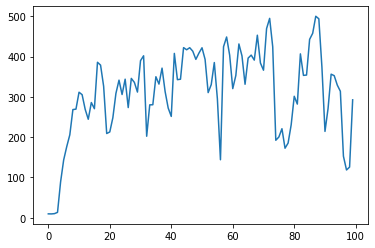

In [113]:
refined_steps_three = []
for i in range(100):
    n = 100 * i
    refined_steps_three.append(np.mean(steps[n:n+100]))
plt.plot(refined_steps_three)